# Fashion-Mnist Project

## Before starting

In this first part we are going to get the essential things we need for the project. This is a classification task, so we have some samples that we have to classify into different classes. Everything is explained in the report.

First of all we get all the libraries we will use. 

Secondly we load the data, using the function given by the professor. In this way, besides loading the data, they are already flatten into a vector. After getting the data we will study them, in order to better understand what we are dealing with. Besides printing the shapes of our data, we will check if they are "regular": if the classes are balanced and if the ranges of the features are similar.

In [1]:
!pip install tensorflow_addons # We need this to save f1_score in the history of the Neural Network

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [2]:
#LIBRARIES

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV        # Grid search (model_gs)
from sklearn.multiclass import OneVsRestClassifier      # One vs Rest (ovr)
from sklearn.tree import DecisionTreeClassifier         # Decision tree (dt)
from sklearn.ensemble import RandomForestClassifier     # Random forest (rf)
from sklearn.svm import LinearSVC                       # LinearSVC (lsvc)
from sklearn.linear_model import SGDClassifier          # SGDClassifier (sgdc)
from sklearn.linear_model import Perceptron             # Perceptron (pt)
from sklearn.neighbors import KNeighborsClassifier      # Knn (knn)

# Neural Network
import tensorflow
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.framework.random_seed import set_random_seed
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.color import rgb2gray


# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


In [3]:
# DATA

from urllib.request import urlopen

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train_val = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train_val = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train_val), 784) 
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train_val, Y_train_val, X_test, Y_test


In [4]:
# Load dataset
X_train_val, Y_train_val, X_test, Y_test = load_fashion_mnist()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, shuffle=False)

# print shapes
print('X train shape: ', X_train.shape, '\tY train shape: ', Y_train.shape)
print('X val shape: ', X_val.shape, '\tY val shape: ', Y_val.shape)
print('X test shape: ', X_test.shape, '\tY test shape: ', Y_test.shape)

# print classes and number of classes
print(f"\nClasses:\t {set(Y_train)}\nNumber of classes:\t {len(set(Y_train))}")

X train shape:  (48000, 784) 	Y train shape:  (48000,)
X val shape:  (12000, 784) 	Y val shape:  (12000,)
X test shape:  (10000, 784) 	Y test shape:  (10000,)

Classes:	 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of classes:	 10


In [5]:
print('Y_train samples per class:', Counter(Y_train))
print('Y_val samples per class:', Counter(Y_val))

Y_train samples per class: Counter({6: 4851, 7: 4820, 8: 4820, 5: 4806, 9: 4796, 3: 4796, 1: 4794, 4: 4785, 2: 4768, 0: 4764})
Y_val samples per class: Counter({0: 1236, 2: 1232, 4: 1215, 1: 1206, 9: 1204, 3: 1204, 5: 1194, 7: 1180, 8: 1180, 6: 1149})


In [6]:
# Check if data is scaled
min_ = []                           # list where we will put the minimum for every feature
max_ = []                           # list where we will put the maximum for every feature
for i in range(X_train.shape[1]):   # for every feature
  min_.append(min(X_train[:, i]))   # append the minimum
  max_.append(max(X_train[:, i]))   # append the maximum
min_ = np.array(min_)               # convert lists in arrays
max_ = np.array(max_)

# print(min_)                       # the minimum are all 0
# print(max_)                       # the maximum are almost all 255

print(max(max_-min_))

255


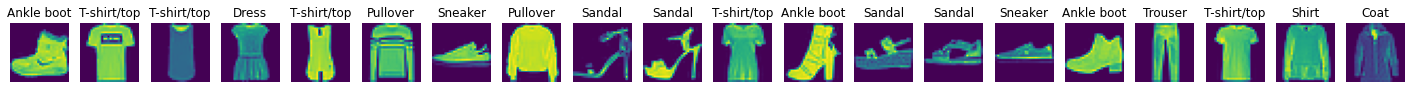

In [7]:
# A look at the examples
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = X_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[Y_train[idx]]}')
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Training the models

Now we are going to train some models that we have studied during the course.

For each model, after defining it, we have fitted the model on X_train and Y_train, predicted the values of X_train and X_val and then computed the f1_score performance. Finally we have also computed the processing time of each model: since the fitting operation for the models is long, it becomes relevant seeing how long it is when we choose the best ones.

We have trained the following models:
1. DECISION TREE
2. RANDOM FOREST
3. SGDCLASSIFIER
4. ONE VS REST PERCEPTRON
5. K NEAREST NEIGHBOURS
6. NEURAL NETWORK

In [8]:
# This function fits the model and predicts on X_train and X_val
def fit_predict(model):
  model.fit(X_train, Y_train)
  Y_train_pred = model.predict(X_train)
  Y_val_pred = model.predict(X_val)
  return Y_train_pred, Y_val_pred

# This function calculates and prints the f1_score on train and val sets
def f1score(Y_pred):
  f1train = f1_score(Y_train, Y_pred[0],average = 'macro')
  f1test = f1_score(Y_val, Y_pred[1],average = 'macro')
  print(f"Train f1_score: {f1train:.4f}")
  print(f"Val f1_score: {f1test:.4f}")
  #return f1train, f1test

# This function prints the processing time in seconds
def ptime(it):
  ft = time.time()
  print(f"\nProcessing time in seconds: {ft-it:.4f}")

### 1) Decision Tree
We will train a decision tree. As parameters we have used min_samples_leaf=2 and implemented also a GridSearch to look for the best value of max_depth among (None, 3, 5, 10).

In [9]:
# 1) DECISION TREE

it = time.time()

dt_grid_params = {
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
}

dt_clf = DecisionTreeClassifier(random_state= 123, min_samples_leaf=2)
dt_v1 = GridSearchCV(dt_clf, dt_grid_params, n_jobs= -1, cv = 2)
Y_pred_dt = fit_predict(dt_v1)
f1score(Y_pred_dt)

ptime(it)

Train f1_score: 0.8532
Val f1_score: 0.8114

Processing time in seconds: 86.9516


In [10]:
print(dt_v1.best_params_)

{'criterion': 'entropy', 'max_depth': 10}


### 2) Random Forest
We will train a Random Forest, with GridSearchCV on some parameters. We have also implemented a "for loop" to look for a good value for min_samples_leaf (trying with 1, 3, 5, 10, 15) and we have decided to use 10. In this way we loose some performance on the training set but we fix a little bit the problem of overfitting. However, some overfitting still remains. To drastically reduce this problem we could have used max_depth=5, instead of None (which is the best parameter found with the GridSearch), but in this way we would have lost performance (going from a f1score of 0.93 on training set and 0.86 on validation to 0.76 on both).

In [11]:
# 2) RANDOM FOREST

it = time.time()

rf_grid_params = {
    'n_estimators': (5, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 7),
}

rf_clf = RandomForestClassifier(random_state= 123, min_samples_leaf=10)
rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 2)
Y_pred_rf = fit_predict(rf_v1)
f1score(Y_pred_rf)

ptime(it)

Train f1_score: 0.9325
Val f1_score: 0.8685

Processing time in seconds: 46.6710


In [12]:
print(rf_v1.best_params_)

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 20}


### 3) SGDClassifier
We wanted to implement a SVC as we did in class, but it was not working. On the documentation about SVC it is written "The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC or SGDClassifier instead". So, instead of using the model SVC, we used the two suggested. The LinearSVC was very slow and required a big number of iterations, so we will present just the second one.

In [13]:
# 3) SGDClassifier

it = time.time()

sgdc = SGDClassifier(random_state=123)
Y_pred_sgdc = fit_predict(sgdc)
f1score(Y_pred_sgdc)

ptime(it)

Train f1_score: 0.8138
Val f1_score: 0.7916

Processing time in seconds: 131.0621


### 4) One vs Rest with Perceptron
Now we will follow the strategy that we have seen in the Notebook Multiclass_classification. So we will create a Perceptron classifier and then train it with a One vs Rest strategy in order to classify the samples into the different classes we have, using GridSearch to choose the best parameters between some possible.

In [14]:
# 4) One vs Rest Perceptron

it = time.time()

pt_grid_params = {
    'estimator__penalty': [None, 'l2'],
    'estimator__alpha': (0.0001, 0.00001, 0.000001),
}

pt_clf = Perceptron(random_state=123)
ovr_pt = OneVsRestClassifier(pt_clf, n_jobs = -1)
pt_gs = GridSearchCV(ovr_pt, pt_grid_params, n_jobs = -1, cv = 2)
Y_pred_pt_gs = fit_predict(pt_gs)
f1score(Y_pred_pt_gs)

ptime(it)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train f1_score: 0.7971
Val f1_score: 0.7824

Processing time in seconds: 59.2140


In [15]:
#print(pt_gs.best_score_)
print(pt_gs.best_params_)

{'estimator__alpha': 0.0001, 'estimator__penalty': None}


### 5) K-nn
We implement now a K-NN model; we try different values of k (2, 4, 6, 8, 10) with a "for loop".

In [16]:
# 5) K-nn

f1score_values_train = []
f1score_values_val = []
process_times = []
k_values = [2, 4, 6, 8, 10]
for k in k_values:
  it = time.time()
  knn = KNeighborsClassifier(n_neighbors=k, weights = 'distance', algorithm = 'brute', p = 2)
  Y_pred_knn = fit_predict(knn)
  f1score_values_train.append(f1_score(Y_train, Y_pred_knn[0],average = 'macro'))
  f1score_values_val.append(f1_score(Y_val, Y_pred_knn[1],average = 'macro'))
  process_times.append(time.time()-it)


f1score on train [1.0, 1.0, 1.0, 1.0, 1.0]
f1score on val [0.8494894056986497, 0.8572414000671763, 0.8564250323813487, 0.856230452538108, 0.8524532452838927]


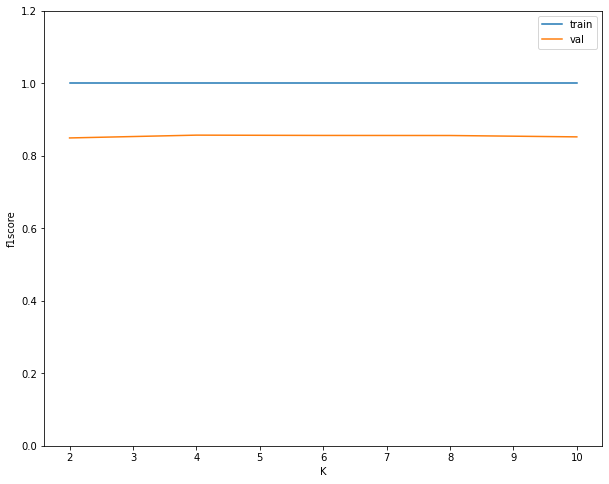

In [17]:
# Print f1score values
print(f"f1score on train {f1score_values_train}")
print(f"f1score on val {f1score_values_val}")
# Plot the f1score values
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, f1score_values_train, label="train")
plt.plot(k_values, f1score_values_val, label="val")
plt.xlabel("K")
plt.ylabel("f1score")
plt.legend()
ax = plt.gca()
ax.set_ylim([0.0, 1.2])
plt.show()

In [18]:
# print the processing times
print(process_times)

[165.77523922920227, 192.3702461719513, 190.35767102241516, 190.49667096138, 190.51822519302368]


### 6) Neural Networks
We have implemented a Neural Network, but with our initial data the performance was very poor: around 0.2 on both training and validation sets. This happened also when we did image classification during the Lab 5. A reason for that maybe is the huge size of the data, that's why in the lecture we decided to reduce their size. 

We will follow the same idea and we will preprocess our data with the HogTrasformer and then scale them with a StandardScaler.

In [19]:
# Preprocessing functions
def rawdata(X):                       # To transform from vector to images
  X_raw = []
  for x in X:
    X_raw.append(x.reshape(28,28))
  return np.array(X_raw)

# We are taking this class from the Lab 5 notebook
class Flatter(BaseEstimator, TransformerMixin):
    """
    Flat an image from 3D to 2D
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array(X).reshape(len(X), -1)


class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])


In [20]:
# Preprocessing data

# From vector to images
X_train_raw = rawdata(X_train)
X_val_raw = rawdata(X_val)
X_test_raw = rawdata(X_test)

# Hog transform
preprocessing = Pipeline([
    ('hog', HogTransformer()),
    ('flatter', Flatter()) 
])

X_train_hog = preprocessing.fit_transform(X_train_raw)
X_val_hog = preprocessing.fit_transform(X_val_raw)
X_test_hog = preprocessing.fit_transform(X_test_raw)
print(f"Shape X_train_hog: {X_train_hog.shape}")

# Scaling the features
scaler = StandardScaler()
scaler.fit(X_train_hog)
X_train_hog_scaled = scaler.transform(X_train_hog)
X_val_hog_scaled = scaler.transform(X_val_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

Shape X_train_hog: (48000, 81)


So, now we have modified the dataset: the number of examples remains the same, but the features are much less than before.

We can implement the Neural Network and see if the perfomance has improved. In the original code we did a "for loop" with the number of _units_ in the hidden layer taking values in [10, 30, 50]. Since the code is already heavy we will not write the loop, but use directly the best number we obtained (i.e. 50). 

In [21]:
# Implementation neural network in the hog_scaled dataset
# Storage of some information
feature_vector_length = X_train_hog.shape[1]
num_classes = 10

# One hot encoding
Y_train_cat = to_categorical(Y_train, num_classes)
Y_val_cat = to_categorical(Y_val, num_classes)
Y_test_cat = to_categorical(Y_test, num_classes)

# Defining the model
it = time.time()
nn = Sequential()
nn.add(Dense(input_dim = feature_vector_length, units = feature_vector_length, activation = "relu"))
nn.add(Dense(units=50, activation = 'relu'))
nn.add(Dense(units = num_classes, activation = 'softmax'))
print(nn.summary())
plot_model(nn, show_shapes= True)

nn.compile(loss='categorical_crossentropy', 
  optimizer='sgd',
  metrics=['accuracy', F1Score(num_classes, average = 'macro')])
  
es = EarlyStopping(monitor='val_loss',     # quantity to be monitored
                   mode='min',             # we look for decreasing patterns stop 
                   patience = 10,          # number of epochs with no improvement
                   verbose=0.1)
  
history = nn.fit(X_train_hog_scaled, Y_train_cat, epochs = 500, batch_size=16, validation_split=0.1, verbose = 0, callbacks = [es])

Y_train_pred_nn = nn.predict(X_train_hog_scaled).argmax(axis = 1)
Y_val_pred_nn = nn.predict(X_val_hog_scaled).argmax(axis = 1)
Y_test_pred_nn = nn.predict(X_test_hog_scaled).argmax(axis = 1)

f1train = f1_score(Y_train_cat.argmax(axis = 1), Y_train_pred_nn, average = 'macro')
f1val = f1_score(Y_val_cat.argmax(axis = 1), Y_val_pred_nn, average = 'macro')
print(f"Train f1_score: {f1train:.4f}")
print(f"Val f1_score: {f1val:.4f}")
ptime(it) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 81)                6642      
                                                                 
 dense_1 (Dense)             (None, 50)                4100      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 11,252
Trainable params: 11,252
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00024: early stopping
Train f1_score: 0.8813
Val f1_score: 0.8462

Processing time in seconds: 94.9087


In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

In [23]:
#print(f"Accuracy: {history.history['accuracy'][0]}\nVal accuracy: {history.history['accuracy'][1]}")

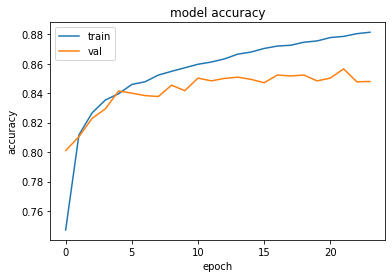

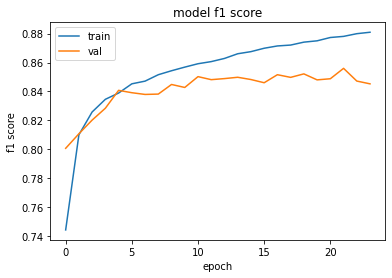

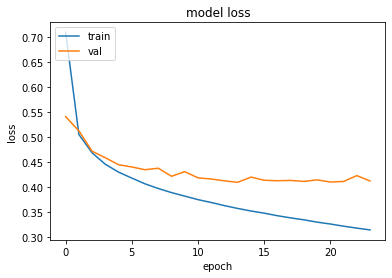

In [24]:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['f1_score'])
  plt.plot(history.history['val_f1_score'])
  plt.title('model f1 score')
  plt.ylabel('f1 score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()



## Selecting the best models

Now we can compare the results we obtained.

Each model is working pretty well but we will focuse just on two of them, in order to analyse better their performance and do some error analysis.
We chose to focuse on the "Decision Tree" and the "Neural Network".
In fact they have good results in terms of f1score and processing time and they don't seem to present particular problems (overfitting or underfitting).

It's time to see their performance on the test set!

In [25]:
print("f1score on test set")
print(f"Decision tree: {f1_score(Y_test,dt_v1.predict(X_test), average='macro'):.4f}")
print(f"Neural Network: {f1_score(Y_test_cat.argmax(axis = 1), Y_test_pred_nn, average = 'macro'):.4f}")
#print(f"Random Forest: {f1_score(Y_test,rf_v1.predict(X_test), average='macro'):.4f}")

f1score on test set
Decision tree: 0.7975
Neural Network: 0.8418


## Error Analysis
The performance is good also on the test sets. We will keep in consideration just the Neural Network for this final part.

Even if our results are good, we can ask ourselves why is the model mispredicting some samples. Let us print the confusion matrix for the Neural Network model: it represents the classes in which the test samples are classified and their real class. 

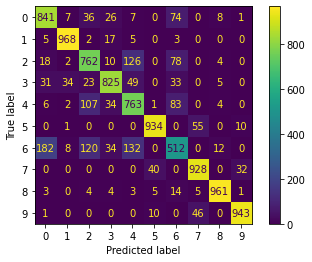

In [26]:
# Confusion matrix for Neural Network
cm = confusion_matrix(Y_test_cat.argmax(axis = 1), Y_test_pred_nn, labels = range(10))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = range(10))
disp.plot()
plt.show()

We can see that for example we have 182 samples of class 6 ('Shirt') mispredicted in class 0 ('T-shirt/Top'). Or 107 samples of class 2 ('Pullover') mispredicted in class 4 ('Coat').

Let us see some of them to see what mistakes we have done:

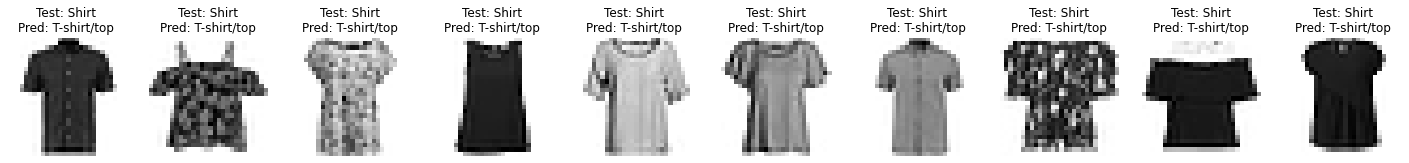

In [27]:
# Predicted 0, test 6
num_images = 10
pred = 0
test = 6
indices = np.all([ (Y_test==test), (Y_test_pred_nn==pred) ], axis=0)
_, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(25, 5))
for ax, image, label, pred_label in zip(axes, X_test[indices][:num_images], [y_labels[test] for x in range(num_images)], [y_labels[pred] for x in range(num_images)]):
    ax.set_axis_off()
    ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest") 
    ax.set_title("Test: %s\nPred: %s" % (label, pred_label))

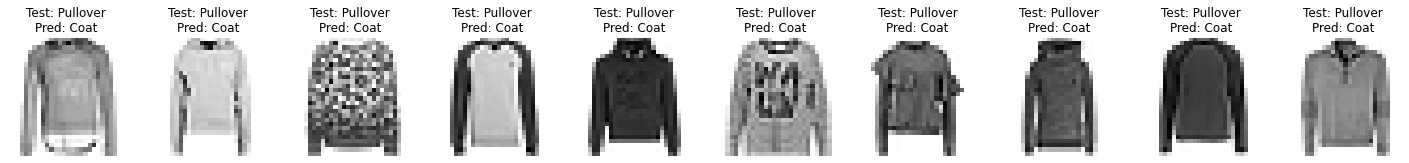

In [28]:
# Predicted 4, test 2
num_images = 10
pred = 4
test = 2
indices = np.all([ (Y_test==test), (Y_test_pred_nn==pred) ], axis=0)
_, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(25, 5))
for ax, image, label, pred_label in zip(axes, X_test[indices][:num_images], [y_labels[test] for x in range(num_images)], [y_labels[pred] for x in range(num_images)]):
    ax.set_axis_off()
    ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Test: %s\nPred: %s" % (label, pred_label))

These mistakes are quite understandable, even a human would make them! 

So we are overall quite satisfied with the way our model is working and the performance it reached.